## <center> MVA 2024 - Time Series </center><br> <center> TP 1 </center>
<br> <center> Samar Rabeh </center>
<br> <center> Hayder Hajlaoui  </center>

# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

/Users/samar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

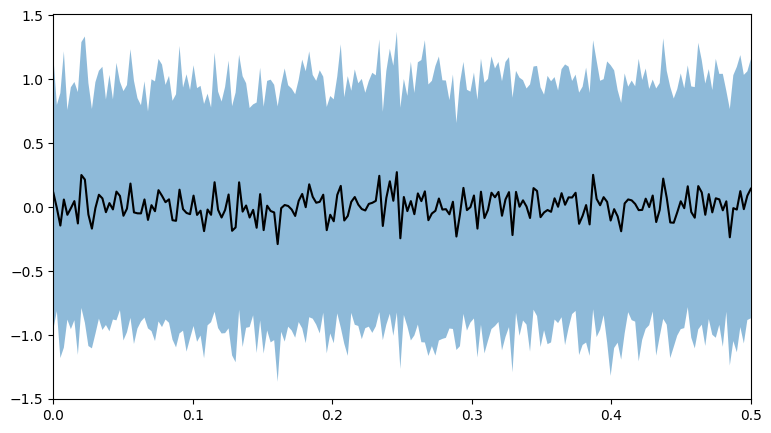

In [53]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
periodograms = np.random.randn(100, 200)  # shape (n_trials, n_freqs)
freqs = np.linspace(0, 0.5, 200)
##


fig, ax = fig_ax(figsize=(9, 5))

avg = periodograms.mean(axis=0)
std = periodograms.std(axis=0)
ax.plot(freqs, avg, 'k-')
ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)


## Question 9

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [3]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

AssertionError: The code 17-1 cannot be found in the data set.

## Question 10

In [ ]:
def get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray) -> float:
    return dtw(signal_1,signal_2).distance

def make_square(jagged):
    max_cols = max(map(len, jagged))
    l= []
    for row in jagged:
        row = list(row)
        row.extend([-1] * (max_cols - len(row)))
        l.append(row)
    return np.array(l)

In [ ]:
X_train_squared = make_square(X_train)
X_tr, X_te, y_tr, y_te = train_test_split(X_train_squared, y_train, test_size=0.25, random_state=42)

clf = KNeighborsClassifier(n_neighbors=1,weights='distance',metric=get_dtw_distance)
parameters= {'n_neighbors':[3, 5, 7, 9]}

grid = GridSearchCV(clf, parameters, cv=5, scoring=make_scorer(f1_score))
grid.fit(X_tr,y_tr)

print('Best parameter: ', grid.best_params_)
print('Best average f1-score: ', grid.best_score_)

ValueError: max() arg is an empty sequence

In [ ]:
# Train model using best parameters on train set
clf_best = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'],weights='distance',metric=get_dtw_distance)
clf_best.fit(X_tr,y_tr) 

# Evaluate best model on test set
y_pred = clf_best.predict(X_te)
print('F1-score on test set = ', f1_score(y_pred,y_te))

## Question 11

In [ ]:
# Find indices and corresponding true classes of badly classified samples
indices_bad_classification = np.where(y_pred != y_te)[0]
class_bad_classification = np.array(y_te)[indices_bad_classification]

# Badly classified step from healthy class
ind_healthy = np.where(class_bad_classification==0)[0][0]
bad_classif_healthy = X_te[indices_bad_classification[ind_healthy]]
bad_classif_healthy = bad_classif_healthy[np.where(bad_classif_healthy!=-1)]

# Badly classified step from non-healthy class
ind_non_healthy = np.where(class_bad_classification==1)[0][0]
bad_classif_non_healthy = X_te[indices_bad_classification[ind_non_healthy]]
bad_classif_non_healthy = bad_classif_non_healthy[np.where(bad_classif_non_healthy!=-1)]

# Display a badly classified step from each class (healthy/non-healthy)
fig , ax = plt.subplots(2,1,figsize=(15,10))
ax[0].plot(bad_classif_healthy)
ax[0].set_title('Healthy case predicted as unhealthy')
ax[1].plot(bad_classif_non_healthy)
ax[1].set_title('Unhealthy case predicted as healthy')
plt.show()